In [12]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
from sklearn.ensemble import ExtraTreesClassifier


# Analysis libs
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [13]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [14]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [17]:
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf = etc.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9998537191896043
Test accuracy: 0.8603447295067979


Original:
- Training accuracy: 0.9998537191896043
- Test accuracy: 0.8600034131634336

w/o 2 extra features:
- Training accuracy: 0.9998537191896043
- Test accuracy: 0.8603447295067979

In [18]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8790,    0,    0,    0],
       [   0, 2026,  400,  511],
       [   0,  349, 2278,  379],
       [   0,  485,  331, 2030]])

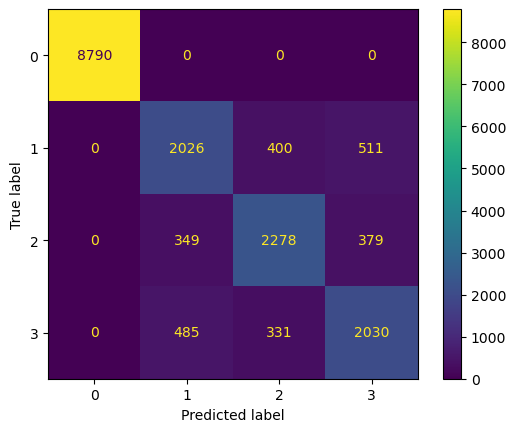

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       0.71      0.69      0.70      2937
           2       0.76      0.76      0.76      3006
           3       0.70      0.71      0.70      2846

    accuracy                           0.86     17579
   macro avg       0.79      0.79      0.79     17579
weighted avg       0.86      0.86      0.86     17579



In [21]:
scores = cross_val_score(clf, X, y, cv=10)

In [22]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.76006826 0.78720137 0.82423208 0.83924915 0.86843003 0.84180887
 0.84075781 0.83051715 0.79313876 0.80098993]
Mean of CV scores: 0.8186393413592578
Standard Deviation of CV scores: 0.030794466153473112
